In [ ]:
!pip install -q transformers torch wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch.nn.functional import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


In [ ]:
# Load the final labeled file directly
merged_df = pd.read_csv("final_comments_labeled.csv")
merged_df['comment_timestamp'] = pd.to_datetime(merged_df['comment_timestamp'])

# Filter for post-launch data only
merged_df = merged_df[merged_df['comment_timestamp'] >= '2025-01-01']


In [ ]:
spec_terms = ["quick flip", "get in", "get out", "exit early", "10x", "moon", "pump", "dump"]
pattern = '|'.join(spec_terms)
merged_df['is_speculative'] = merged_df['comment_body'].str.contains(pattern, case=False, na=False)


In [ ]:
merged_df[['topic_num', 'topic_label']].head()


,topic_num,topic_label
0,1,Moderation & Reddit Comments
1,3,"Sarcasm, Grift & Humor"
2,4,Coin Speculation & Crypto Trading
3,3,"Sarcasm, Grift & Humor"
4,3,"Sarcasm, Grift & Humor"


In [ ]:
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
merged_df['sentiment_score'] = merged_df['predicted_label'].map(sentiment_map)
merged_df['time_bin'] = merged_df['comment_timestamp'].dt.floor('4H')


<ipython-input-22-83e8efdb20db>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  merged_df['time_bin'] = merged_df['comment_timestamp'].dt.floor('4H')


In [ ]:
price_df = pd.read_excel("kraken_TRUMPUSDT_4h_data.xlsx")
price_df['Time'] = pd.to_datetime(price_df['Time'])

sentiment_avg = merged_df.groupby('time_bin')['sentiment_score'].mean().reset_index()
sentiment_avg.rename(columns={'time_bin': 'Time', 'sentiment_score': 'avg_sentiment'}, inplace=True)
price_sentiment_df = pd.merge(price_df, sentiment_avg, on='Time', how='left')


In [ ]:
rugpull_time = pd.to_datetime("2025-01-20 16:00:00")
pre = price_sentiment_df[price_sentiment_df['Time'] < rugpull_time]['avg_sentiment'].dropna()
post = price_sentiment_df[price_sentiment_df['Time'] >= rugpull_time]['avg_sentiment'].dropna()
t_stat, p_value = ttest_ind(pre, post, equal_var=False)


In [ ]:
topic_trend = merged_df.groupby(['topic_label', 'time_bin'])['sentiment_score'].mean().reset_index()


<ipython-input-30-cf0930c333f7>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sentiment_avg = merged_df.groupby(merged_df['comment_timestamp'].dt.floor('4H'))['sentiment_score'].mean().reset_index()


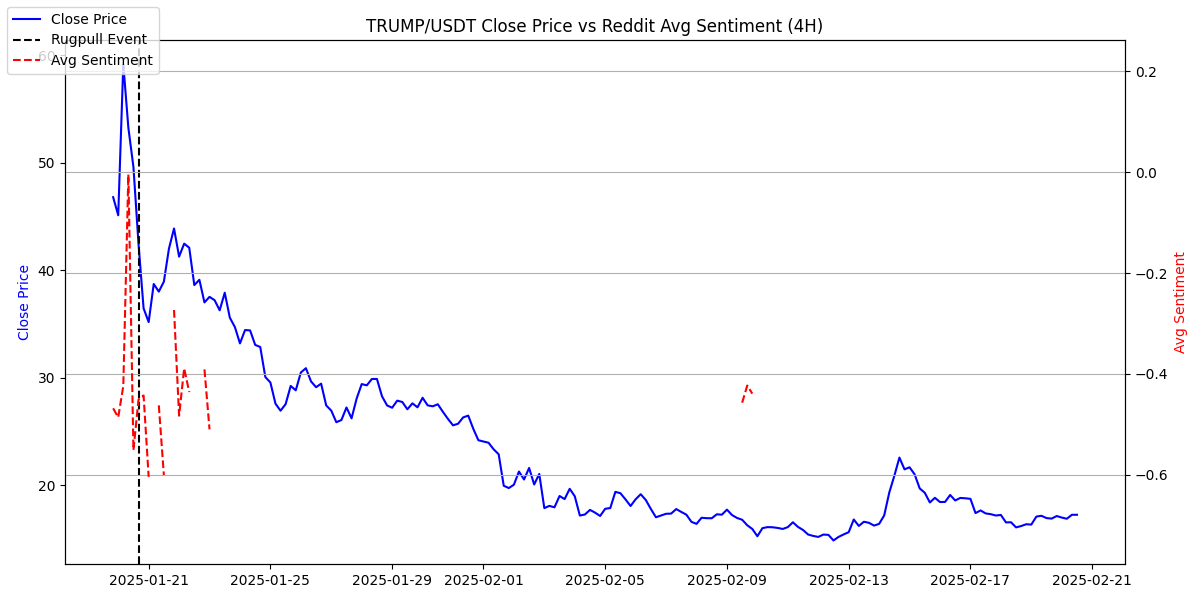

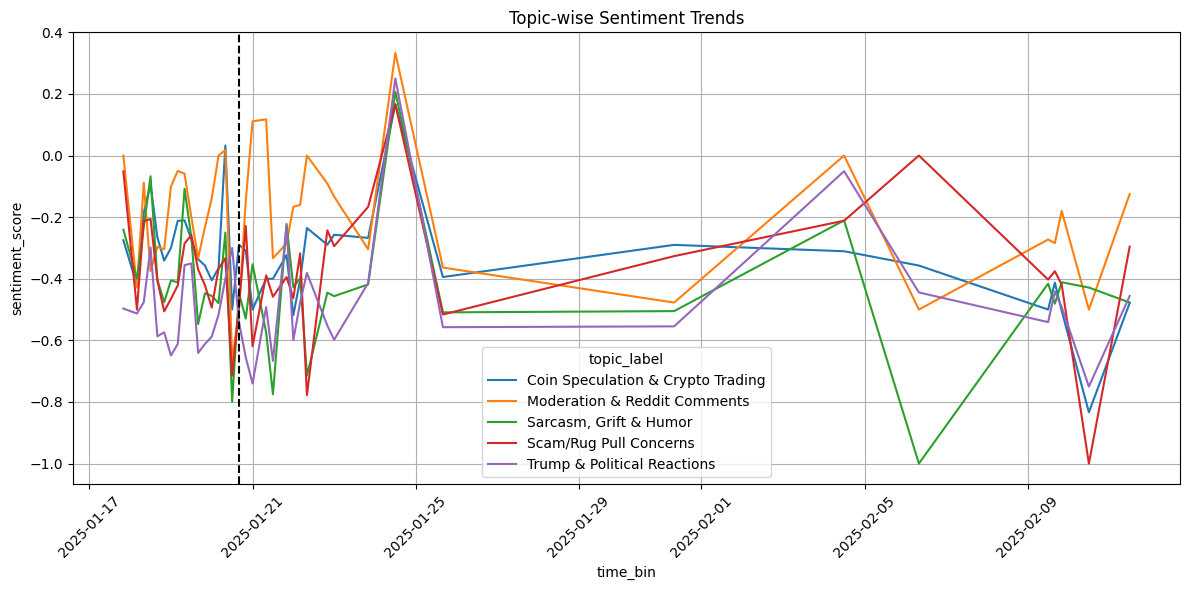

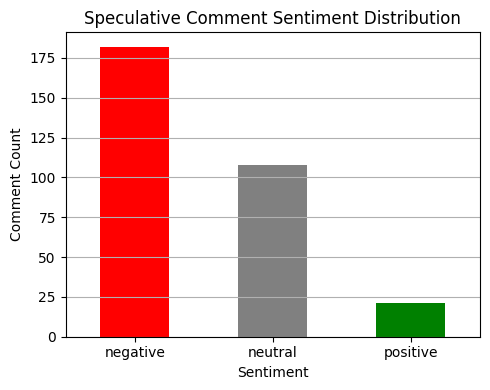

In [ ]:
# Step 1: Group sentiment into 4H bins
sentiment_avg = merged_df.groupby(merged_df['comment_timestamp'].dt.floor('4H'))['sentiment_score'].mean().reset_index()
sentiment_avg.rename(columns={'comment_timestamp': 'Time', 'sentiment_score': 'avg_sentiment'}, inplace=True)

# Step 2: Merge with Kraken price (which is already 4H)
price_df['Time'] = pd.to_datetime(price_df['Time'])  # ensure datetime
price_sentiment_df = pd.merge(price_df, sentiment_avg, on='Time', how='left')

# Step 3: Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Kraken price
ax1.plot(price_sentiment_df['Time'], price_sentiment_df['Close'], color='blue', label='Close Price')
ax1.set_ylabel("Close Price", color='blue')
ax1.axvline(x=pd.to_datetime("2025-01-20 16:00:00"), color='black', linestyle='--', label='Rugpull Event')

# Reddit avg sentiment
ax2 = ax1.twinx()
ax2.plot(price_sentiment_df['Time'], price_sentiment_df['avg_sentiment'], color='red', linestyle='--', label='Avg Sentiment')
ax2.set_ylabel("Avg Sentiment", color='red')

# Titles and formatting
plt.title("TRUMP/USDT Close Price vs Reddit Avg Sentiment (4H)")
fig.legend(loc="upper left")
plt.grid()
plt.tight_layout()
plt.show()

# --- 13.2 Topic Sentiment Trends ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=topic_trend, x='time_bin', y='sentiment_score', hue='topic_label')
plt.axvline(x=rugpull_time, color='black', linestyle='--')
plt.title("Topic-wise Sentiment Trends")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# --- 13.3 Speculative Sentiment Bar Chart ---
spec_df = merged_df[merged_df['is_speculative'] & (merged_df['comment_score'] >= 5)]
plt.figure(figsize=(5, 4))
spec_df['predicted_label'].value_counts().plot(kind='bar', color=['red', 'gray', 'green'])
plt.title("Speculative Comment Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Comment Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<ipython-input-35-64fb2bf3e00d>:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['time_bin'] = df['timestamp'].dt.floor('4H')


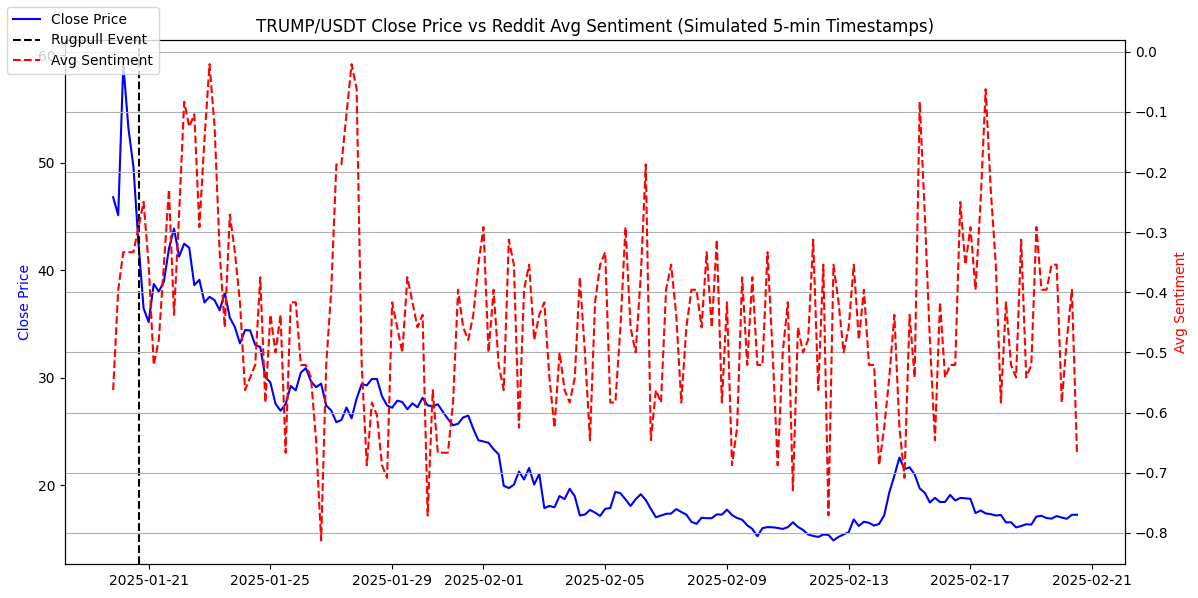

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load final labeled Reddit data
df = pd.read_csv("final_comments_labeled.csv")
df = df.dropna(subset=['comment_body', 'predicted_label']).reset_index(drop=True)

# Step 2: Load Kraken data
price_df = pd.read_excel("kraken_TRUMPUSDT_4h_data.xlsx")
price_df['Time'] = pd.to_datetime(price_df['Time'])

# Step 3: Simulate 5-min timestamps starting from Kraken's first price timestamp
df['timestamp'] = pd.date_range(
    start=price_df['Time'].min(),
    periods=len(df),
    freq='5min'
)

# Step 4: Sentiment mapping + binning
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_score'] = df['predicted_label'].map(sentiment_map)
df['time_bin'] = df['timestamp'].dt.floor('4H')
sentiment_avg = df.groupby('time_bin')['sentiment_score'].mean().reset_index()
sentiment_avg.rename(columns={'time_bin': 'Time', 'sentiment_score': 'avg_sentiment'}, inplace=True)

# Step 5: Merge with price data
merged_df = pd.merge(price_df, sentiment_avg, on='Time', how='left')

# Step 6: Plot with rugpull marker
rugpull_time = pd.to_datetime("2025-01-20 16:00:00")

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(merged_df['Time'], merged_df['Close'], color='blue', label='Close Price')
ax1.axvline(x=rugpull_time, color='black', linestyle='--', label='Rugpull Event')
ax1.set_ylabel("Close Price", color='blue')

ax2 = ax1.twinx()
ax2.plot(merged_df['Time'], merged_df['avg_sentiment'], color='red', linestyle='--', label='Avg Sentiment')
ax2.set_ylabel("Avg Sentiment", color='red')

plt.title("TRUMP/USDT Close Price vs Reddit Avg Sentiment (Simulated 5-min Timestamps)")
fig.legend(loc="upper left")
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
print(merged_df['comment_timestamp'].min(), merged_df['comment_timestamp'].max())


2025-01-17 22:04:22 2025-02-11 12:51:51



📌 Speculative Comment Sentiment Distribution:
predicted_label
negative    0.585209
neutral     0.347267
positive    0.067524
Name: proportion, dtype: float64

📌 Sentiment Shift Test (T-Test):
Pre-rugpull avg sentiment: -0.38711064644167836
Post-rugpull avg sentiment: -0.4185624564780319
T-statistic: 0.2997431554996203
P-value: 0.7758342963411591


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


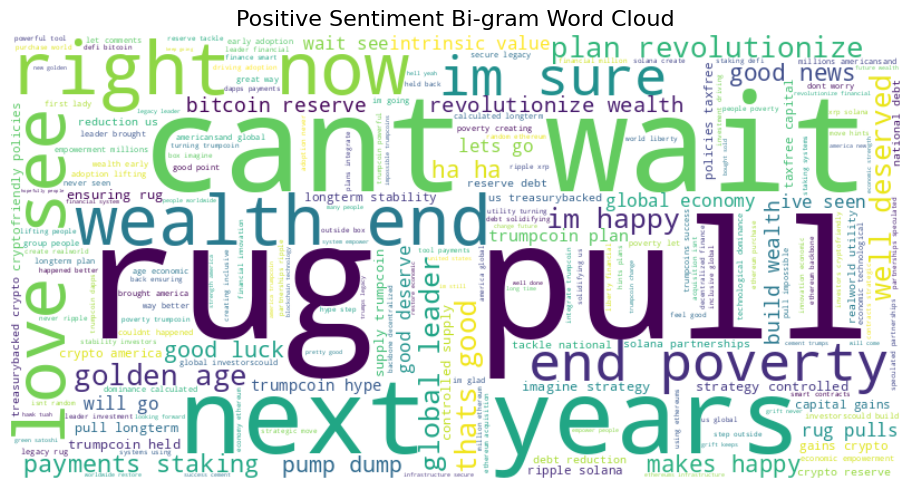

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


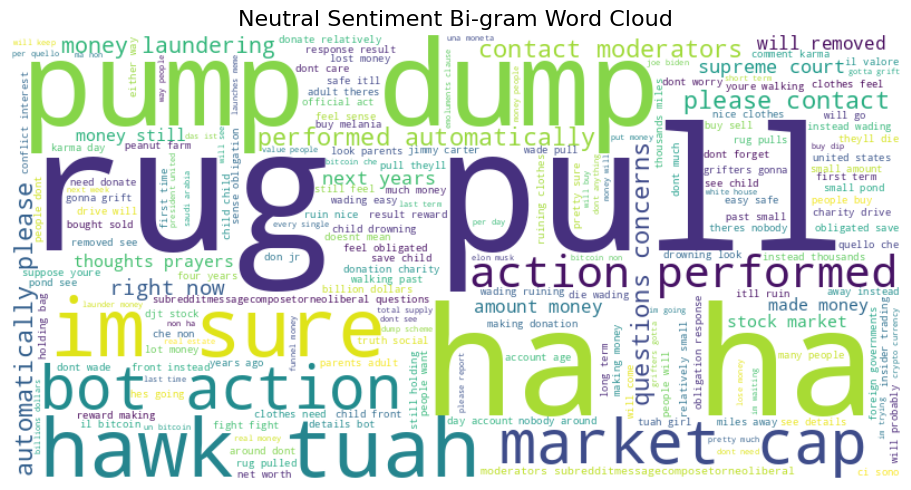

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


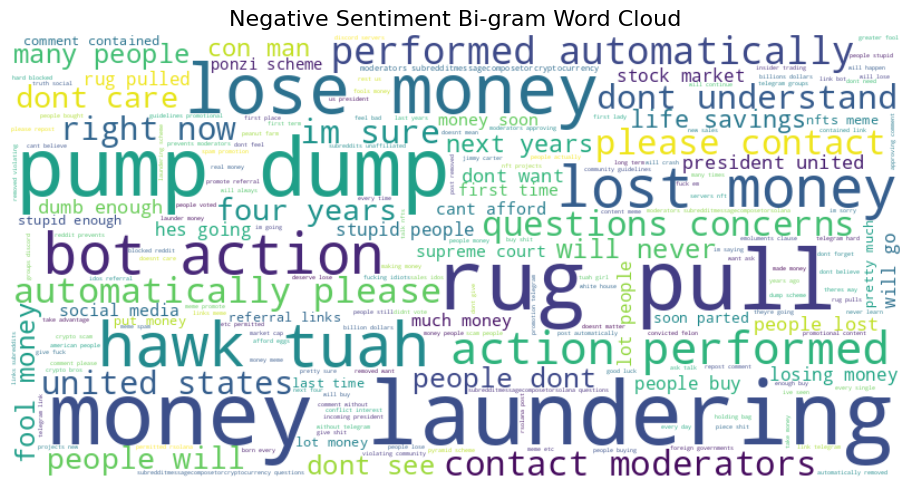

In [ ]:
print("\n📌 Speculative Comment Sentiment Distribution:")
print(spec_df['predicted_label'].value_counts(normalize=True))

print("\n📌 Sentiment Shift Test (T-Test):")
print("Pre-rugpull avg sentiment:", pre.mean())
print("Post-rugpull avg sentiment:", post.mean())
print("T-statistic:", t_stat)
print("P-value:", p_value)

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
import re
import matplotlib.pyplot as plt

# Custom stopwords
custom_stopwords = list(STOPWORDS)
custom_stopwords += [
    "trump", "coin", "coins", "like", "just", "get", "got", "make", "really",
    "think", "know", "say", "thing", "one", "even", "https", "www", "com", "amp"
]

# Clean text before vectorizing
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # remove numbers, punctuation
    return text

# Generate bigrams after cleaning
def generate_bigrams(text_series):
    cleaned = text_series.apply(clean_text)
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=custom_stopwords)
    X = vectorizer.fit_transform(cleaned)
    sum_words = X.sum(axis=0)
    bigram_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
    return dict(bigram_freq)

# Plot word cloud
def plot_bigram_wordcloud(frequencies, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Loop through sentiments
for sentiment in ['positive', 'neutral', 'negative']:
    text_series = merged_df[merged_df['predicted_label'] == sentiment]['comment_body'].dropna().astype(str)
    bigrams = generate_bigrams(text_series)
    plot_bigram_wordcloud(bigrams, f"{sentiment.capitalize()} Sentiment Bi-gram Word Cloud")


<ipython-input-36-4bc5a0515157>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_df, x='rugpull_period', y='avg_sentiment', palette='Reds')


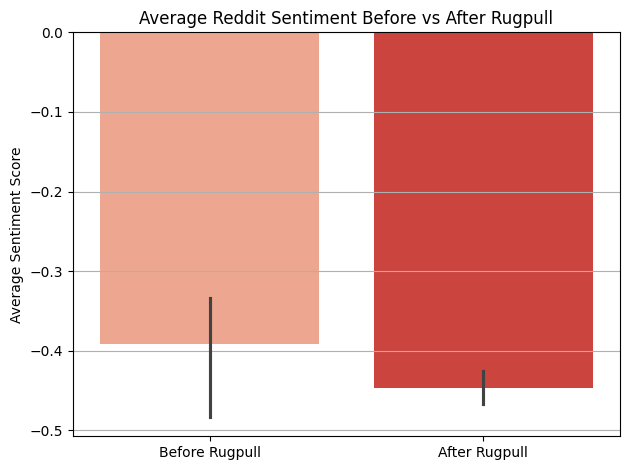

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add label column
merged_df['rugpull_period'] = merged_df['Time'].apply(
    lambda x: 'Before Rugpull' if x < pd.to_datetime("2025-01-20 16:00:00") else 'After Rugpull'
)

# Plot bar chart of avg sentiment
sns.barplot(data=merged_df, x='rugpull_period', y='avg_sentiment', palette='Reds')
plt.title('Average Reddit Sentiment Before vs After Rugpull')
plt.ylabel('Average Sentiment Score')
plt.xlabel('')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
